# Setup

In [1]:
DATA_FILE_NAME = "consultation-documents-preprocessed-2025-01-06.parquet"

DOCUMENT_SOURCES = {
    "fedlex",
    # "openparldata",
}
LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

# EMBEDDING_MODEL = "openai/text-embedding-ada-002"
EMBEDDING_MODEL = "openai/text-embedding-3-large"

# FROM_YEAR = 2010
FROM_YEAR = 2000

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 2718
USE_TEST_SET = False

%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


In [55]:
%load_ext autoreload
%autoreload 2

import logging
import pathlib
import sys
from typing import Any

import dotenv
import mlflow
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from research.document_types import document_title_rule_model
from research.lib import data_access, embeddings, plotting

In [4]:
dotenv.load_dotenv()

True

In [5]:
mlflow.set_experiment(f"V1. {'&'.join(sorted(LANGUAGES))}. document types")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("document_sources", sorted(DOCUMENT_SOURCES))
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("embedding_model", EMBEDDING_MODEL)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

Starting run: delicate-hog-125


''

In [6]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/01/13 09:21:53 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

In [8]:
df_input = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_document_sources=DOCUMENT_SOURCES,
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_input

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '/Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-01-06.parquet'. Exception: 
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input da

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",DRAFT,de,Vernehmlassungsvorlage,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...
3,4,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",RECIPIENT_LIST,de,Adressatenliste,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
6,7,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",LETTER,de,Begleitschreiben 2,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
9,10,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",REPORT,de,Erläuternder Bericht,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,1. Oktober 2021 \n \n \n \n \nVerordnung des B...
12,13,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",LETTER,de,Begleitschreiben 1,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52027,53636,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/2b64exk2,"[energy, spatial_planning]",LETTER,de,Begleitschreiben,44,Bundesamt für Energie,ch,2024-11-05 11:39:50,fedlex,manual,Schweizerische Eidgenossenschaft\nConfëdëratio...
52030,53639,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/2b64exk2,"[energy, spatial_planning]",LETTER,de,Begleitschreiben-2,44,Bundesamt für Energie,ch,2024-11-05 11:39:50,fedlex,manual,Schweizerische Eidgenossenschaft\nConfëdëratio...
52033,53642,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/2b64exk2,"[energy, spatial_planning]",REPORT,de,Erläuternder Bericht,44,Bundesamt für Energie,ch,2024-11-05 11:39:50,fedlex,manual,BFE-D-BDD93401/157\n \nEidgenössisches Departe...
52036,53645,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https:/

In [9]:
df_input["document_type"].value_counts(dropna=False)

document_type
LETTER            3084
DRAFT             2898
REPORT            2153
RECIPIENT_LIST    1770
FINAL_REPORT      1747
OPINION            985
VARIOUS_TEXT       418
SYNOPTIC_TABLE      81
SURVEY              13
RESPONSE_FORM        7
DECISION             0
LINK                 0
Name: count, dtype: int64

## Define the target

In [10]:
y_encoder = OrdinalEncoder(dtype=int)
df_input["document_type_code"] = y_encoder.fit_transform(df_input[["document_type"]])

## Drop empty documents

In [11]:
empty_index = df_input["document_content_plain"] == ""
empty_count = len(df_input[empty_index])
print(f"Empty texts: {empty_count} ({100 * empty_count / len(df_input):.1f}%)")

Empty texts: 705 (5.4%)


In [12]:
df_input = df_input.loc[~empty_index]

## Splits

### Set aside a test set

In [13]:
splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(X=df_input, y=df_input["document_type_code"]))

In [14]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (11205, 20)
Test: (1246, 20)


In [15]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

1246

### Prepare a cross-validation splitter

In [16]:
cv_splitter = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Embeddings

## Tokenise and truncate to input window

In [17]:
embedding_model = embeddings.create_embedding_model(EMBEDDING_MODEL)
mlflow.log_param("embedding_model.max_input_tokens", embedding_model.max_input_tokens)

tokens_train = df_input_train["document_content_plain"].progress_map(embedding_model.tokenize)
tokens_test = df_input_test["document_content_plain"].progress_map(embedding_model.tokenize)

100%|██████████| 1246/1246 [00:03<00:00, 322.84it/s]


## Embed

In [18]:
with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
) as get_embeddings:
    embeddings_train = get_embeddings(tokens_train.tolist())
    print(embeddings_train.shape)
    embeddings_test = get_embeddings(tokens_test.tolist())
    print(embeddings_test.shape)

Embedding (cached=11204, new=0): 100%|██████████| 11205/11205 [00:07<00:00, 1546.19it/s]


(11205, 3072)


Embedding (cached=1245, new=0): 100%|██████████| 1246/1246 [00:00<00:00, 1580.31it/s]


(1246, 3072)


# Classification

In [19]:
X_train = embeddings_train
X_test = embeddings_test
y_train = df_input_train["document_type_code"]
y_test = df_input_test["document_type_code"]

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (11205, 3072) (11205,)
Test (1246, 3072) (1246,)


In [20]:
classifier = make_pipeline(
    StandardScaler(),
    # PCA(n_components=200, random_state=RANDOM_STATE),
    LogisticRegression(max_iter=1000),
)
classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [21]:
if "pca" in classifier.named_steps:
    mlflow.log_param("pca_n_components", classifier.named_steps["pca"].get_params()["n_components"])

In [22]:
def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scoring,
)
scores_docs

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

{'fit_time': array([1.40215492, 0.89028192, 0.95010495, 0.95532393, 0.82745504]),
 'score_time': array([0.03410888, 0.02052212, 0.02562094, 0.02006793, 0.02037692]),
 'test_precision': array([0.94604148, 0.95137891, 0.94749069, 0.95067906, 0.94861341]),
 'test_recall': array([0.94957608, 0.95403838, 0.95046854, 0.95314592, 0.95046854]),
 'test_f1': array([0.94739411, 0.95250867, 0.94856175, 0.95127688, 0.94939214]),
 'test_pca_explained_variance': array([nan, nan, nan, nan, nan])}

## Evaluation of the cross-validation

In [23]:
avg_scores_docs = {k: np.round(np.mean(v), 4) for k, v in scores_docs.items()}
mlflow.log_metrics({f"{k}_docs": v for k, v in avg_scores_docs.items() if k.startswith("test_")})

print("Per-document CV scores:")
print(f"Precision: {avg_scores_docs['test_precision']:.4f} (+/- {np.std(scores_docs['test_precision']):.4f})")
print(f"Recall:    {avg_scores_docs['test_recall']:.4f} (+/- {np.std(scores_docs['test_recall']):.4f})")
print(f"F1:        {avg_scores_docs['test_f1']:.4f} (+/- {np.std(scores_docs['test_f1']):.4f})")

Per-document CV scores:
Precision: 0.9488 (+/- 0.0020)
Recall:    0.9515 (+/- 0.0017)
F1:        0.9498 (+/- 0.0018)


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

In [24]:
cv_test_splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train_index, cv_test_index = next(cv_test_splitter.split(X=X_train, y=y_train))

X_cv_train = X_train[cv_train_index]
y_cv_train = y_train.iloc[cv_train_index]
X_cv_test = X_train[cv_test_index]
y_cv_test = y_train.iloc[cv_test_index]

In [25]:
classifier.fit(X_cv_train, y_cv_train)
cv_test_predictions = classifier.predict(X_cv_test)

2025/01/13 09:23:55 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/01/13 09:23:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

                precision    recall  f1-score   support

         DRAFT       0.94      0.93      0.94       259
  FINAL_REPORT       0.99      0.98      0.98       157
        LETTER       0.99      1.00      0.99       221
       OPINION       0.98      0.98      0.98        87
RECIPIENT_LIST       1.00      1.00      1.00       158
        REPORT       0.93      0.95      0.94       193
 RESPONSE_FORM       0.00      0.00      0.00         1
        SURVEY       0.00      0.00      0.00         1
SYNOPTIC_TABLE       0.00      0.00      0.00         7
  VARIOUS_TEXT       0.62      0.62      0.62        37

      accuracy                           0.95      1121
     macro avg       0.64      0.65      0.65      1121
  weighted avg       0.95      0.95      0.95      1121



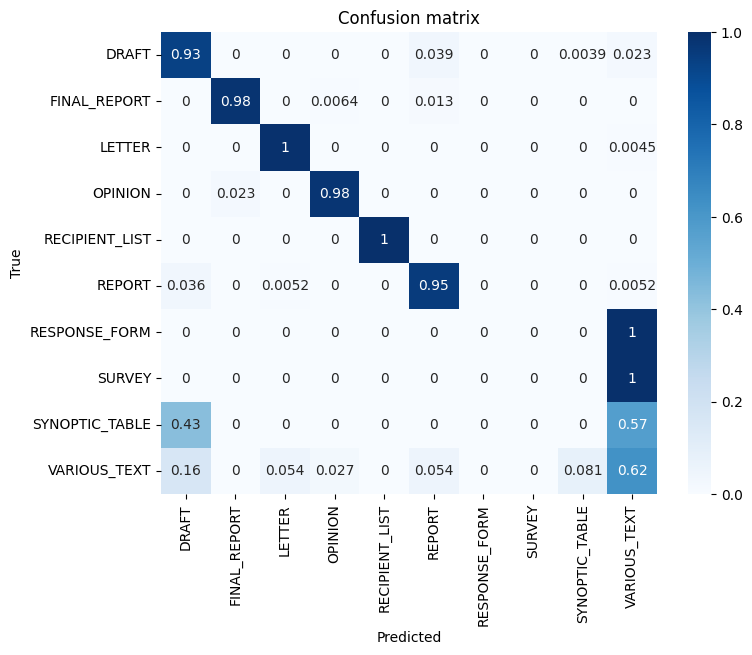

In [26]:
target_names = y_encoder.categories_[0]
print(
    sklearn.metrics.classification_report(
        y_cv_test,
        cv_test_predictions,
        target_names=target_names,
        labels=range(len(target_names)),
    )
)

display(plotting.plot_confusion_matrix_heatmap(y_cv_test, cv_test_predictions, target_names=target_names))

***

## Evaluation on the test set (USE SPARINGLY)

In [27]:
if USE_TEST_SET:
    classifier.fit(X_train, y_train)
    test_ground_truth_docs = y_test
    test_predictions_docs = classifier.predict(X_test)

    print("docs: ground truth", test_ground_truth_docs.shape)
    print("docs: predictions", test_predictions_docs.shape)

    print(
        sklearn.metrics.classification_report(
            test_ground_truth_docs,
            test_predictions_docs,
            target_names=y_encoder.categories_[0],
            labels=range(len(y_encoder.categories_[0])),
        )
    )

In [28]:
if USE_TEST_SET:
    display(
        plotting.plot_confusion_matrix_heatmap(
            test_ground_truth_docs, test_predictions_docs, target_names=y_encoder.categories_[0]
        )
    )

***

# Comparison to the rule-based model

## Load (unlabelled) OpenParlData

In [29]:
df_opd = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_document_sources={"openparldata"},
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_opd

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '/Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-01-06.parquet'. Exception: 
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input da

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain
38324,38325,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 1 zum Anhörungsbericht (Statuten) (PDF...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,Beilage 1 \nVerabschiedet durch Politisches Gr...
38325,38326,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 2 zum Anhörungsbericht (Aktionärbindun...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,"Stand: 20. November 2018, mit formalen Ergänzu..."
38326,38327,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 3 zum Anhörungsbericht (Eignerstrategi...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,Seite 1 von 2 Stand: 20. November 2018 \n\nEig...
38327,38328,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 4 zum Anhörungsbericht (NOK-Gründungsv...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,731.120\n\nSchaffhauser Rechtsbuch 1997 1\n\nV...
38328,38329,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,"Anhörungsbericht (PDF, 10 Seiten, 184 KB)",141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,J:\03_Geschäfte\1_Vorträge\05_AE\Auflösung NOK...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52007,53616,4991,2024-12-18,2025-02-20,Bericht «Sonderpädagogik der St.Galler Volkssc...,Die Regierung des Kantons St.Gallen hat an ihr...,https://www.sg.ch/news/sgch_allgemein/2024/12/...,https://www.demokratis.ch/vernehmlassung/4tpw3ygc,[education],VARIOUS_TEXT,de,Bericht Sonderpädagogik der St.Galler Volksschule,156,Regierung des Kantons St. Gallen,sg,NaT,openparldata,openparldata,Kanton St.Gallen \nBildungsdepartement \n \nAm...
52008,53617,4991,2024-12-18,2025-02-20,Bericht «Sonderpädagogik der St.Galler Volkssc...,Die Regierung des Kantons St.Gallen hat an ihr...,https://www.sg.ch/news/sgch_allgemein/2024/12/...,https://www.demokratis.ch/vernehmlassung/4tpw3ygc,[education],VARIOUS_TEXT,de,Anhang 1: Bericht der Paedagogischen Hochschul...,156,Regierung des Kantons St. Gallen,sg,NaT,openparldata,openparldata,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...
52039,53648,4994,2024-12-19,2025-03-19,Vernehmlassung zum Erlass eines Gesetzes über ...,Die Bündner Regierung hat im Rahmen der Teilre...,https://www.gr.ch/DE/publikationen/vernehmlass...,https://www.demokratis.ch/vernehmlassung/v3tefzb7,[education],VARIOUS_TEXT,de,Einladungsschreiben,150,Regierung des Kantons Graubünden,gr,NaT,openparldata,openparldata,"info@ekud.gr.ch \nwww.ekud.gr.ch\nErziehungs-,..."
52040,53649,4994,2024-12-19,2025-03-19,Vernehmlassung zum Erlass eines Gesetzes über ...,Die Bündner Regierung hat im Rahmen der Teilre...,https://www.gr.ch/DE/publikationen/vernehmlass...,https://www.demokratis.ch/vernehmlassung/v3tefzb7,[education],VARIOUS_TEXT,de,Erlass,150,Regierung des Kantons Graubünden,gr,NaT,openparlda

In [31]:
df_opd["document_type"].value_counts(dropna=False, normalize=True)

document_type
NaN               0.991777
VARIOUS_TEXT      0.002639
LETTER            0.001320
REPORT            0.001117
DRAFT             0.001015
SYNOPTIC_TABLE    0.000914
RECIPIENT_LIST    0.000812
SURVEY            0.000406
DECISION          0.000000
FINAL_REPORT      0.000000
LINK              0.000000
OPINION           0.000000
RESPONSE_FORM     0.000000
Name: proportion, dtype: float64

In [33]:
df_opd = df_opd.loc[df_opd["document_type"].isna()]

## Embed the OPD documents

In [34]:
tokens_opd = df_opd["document_content_plain"].progress_map(embedding_model.tokenize)

with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
) as get_embeddings:
    embeddings_opd = get_embeddings(tokens_opd.tolist())
    print(embeddings_opd.shape)

Embedding (cached=9766, new=3): 100%|█████████▉| 9767/9770 [00:06<00:00, 1523.87it/s]


(9770, 3072)


In [36]:
df_opd["embedding"] = embeddings_opd.tolist()

## Draw random OPD documents and classify them with both the rule-based model and the sklearn model

In [100]:
sample_batch = df_opd.sample(10)

In [101]:
sample_batch["prediction_rule"] = document_title_rule_model.predict(sample_batch).tolist()

sample_predictions = classifier.predict(sample_batch["embedding"].tolist())
sample_batch["prediction_ml"] = y_encoder.inverse_transform(sample_predictions.reshape(-1, 1)).reshape(1, -1)[0]

2025/01/13 11:01:37 WARNING mlflow.sklearn: Unrecognized dataset type <class 'list'>. Dataset logging skipped.


Copy the sample to the clipboard...

In [102]:
sample_batch[["document_id", "document_source_url", "document_title"]].to_clipboard(index=False)

...after you have added the true labels, run this to load them back in here:

In [103]:
ground_truth = pd.read_excel(REPOSITORY_ROOT / "research" / "document_types" / "ground_truth.xlsx")[
    ["document_id", "ground_truth"]
].set_index("document_id")
sample_batch = sample_batch.join(ground_truth, on="document_id")

In [104]:
sample_batch[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "ground_truth",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,ground_truth,prediction_rule,prediction_ml
42595,43237,lu,vnl,doc,Verordnungsentwurf,nan,DRAFT,DRAFT
47317,48204,zh,vnl,doc,Begleitschreiben Vernehmlassung Aufnahmeverordnung,nan,LETTER,LETTER
47933,48844,nw,vnl,doc,01_RRB 691_Teilrevision Pensionskassengesetz PKG_Antrag an LR,nan,VARIOUS_TEXT,REPORT
48752,49695,tg,vnl,doc,Mitwirkungsbericht_Bevölkerungsschutzgesetz,nan,None,OPINION
42997,43640,nw,vnl,doc,02_Bericht RR an LR_kKGSG,nan,REPORT,REPORT
49801,50806,ur,vnl,doc,Auswertungsbericht Vernehmlassung,nan,FINAL_REPORT,OPINION
44325,44975,sz,vnl,doc,Fragebogen,nan,SURVEY,VARIOUS_TEXT
46697,47584,zh,vnl,doc,Vernehmlassungsentwurf,nan,DRAFT,VARIOUS_TEXT
40996,41134,bl,vnl,doc,Begleitschreiben,nan,LETTER,LETTER
49354,50359,nw,vnl,doc,01_RRB 603_Antrag an LR,nan,VARIOUS_TEXT,REPORT


In [93]:
sample_batch.loc[sample_batch["document_id"] == 43586]  # noqa: PLR2004

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,...,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain,embedding,prediction_rule,prediction_ml,ground_truth
42943,43586,3299,2018-11-14,2019-02-08,Vernehmlassung zur Totalrevision des Gesetzes ...,,https://www.nw.ch/_doc/187636,https://www.demokratis.ch/vernehmlassung/z76mgsec,[health],NaN,...,Regierungsrat des Kantons Nidwalden,nw,NaT,openparldata,openparldata,Antrag an den Landrat 714.1 \n 1 \nGesetz \nü...,"[0.006048629991710186, -0.012576724402606487, ...",None,DRAFT,NaN


***

# End MLflow run

In [29]:
mlflow.end_run()